# DAPC method for V. destructor and V. jacobsoni

The file `/work/MikheyevU/Maeva/varroa-jump/data/bayesian/varsubset/filtered_7chr.vcf.gz` contains 3 603 988 bi-allelic variants called from the seven main chromosomes of V. destructor (BEIS01000001.1-BEIS01000007.1). 

For each chromosome, I used this filtering method from the vcf file generated by Snakemake:

`vcftools --gzvcf /work/MikheyevU/Maeva/varroa-jump/data/var/filtered.vcf.gz --chr BEIS01000001.1 --recode-INFO-all --max-alleles 2 --min-alleles 2 --out filteredchr1 --recode`

In a first step I just randomly selected a subset of 500 000 SNPs on which I will be using for DAPC approach.

`shuf <(zcat filtered_7chr.vcf.gz  | grep -v "^#" |cut -f-2 ) |head -500000 > random500000.txt`
`vcftools --gzvcf filtered_7chr.vcf.gz --recode-INFO-all --max-alleles 2 --out varroa500000 --positions random500000.txt --recode`


Now using he packages vcfR and adegenet, let's explore quickly the data so we can define what is a population for ABC approach.

In [ ]:
##Setting the path for the packages
setwd("/work/MikheyevU/Maeva/varroa-jump/data/R")
.libPaths("/home/m/maeva-techer/R/x86_64-redhat-linux-gnu-library/3.2")

In [5]:
##Import packages we will need
library(ade4)
library(ape)
library(adegenet)
library(ggplot2)
library(vcfR)
library(adegraphics)
library(pegas)
library(StAMPP)
library(lattice)
library(gplots)
library(ggmap) 
library(poppr)
library(RColorBrewer)
library(gridExtra)
library(ggplot2)
library(igraph)
library(gridExtra)

Warning message:
“replacing previous import ‘Matrix::expm’ by ‘expm::expm’ when loading ‘spdep’”
   /// adegenet 2.1.0 is loaded ////////////

   > overview: '?adegenet'
   > tutorials/doc/questions: 'adegenetWeb()' 
   > bug reports/feature requests: adegenetIssues()



   *****       ***   vcfR   ***       *****
   This is vcfR 1.5.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


Attaching package: ‘adegraphics’

The following object is masked from ‘package:ape’:

    zoom

The following objects are masked from ‘package:ade4’:

    kplotsepan.coa, s.arrow, s.class, s.corcircle, s.distri, s.image,
    s.label, s.logo, s.match, s.traject, s.value, table.value,
    triangle.class


Attaching package: ‘pegas’

The following object is masked from ‘package:vcfR’:

    getINFO

The following object is masked from ‘package:ape’:

    mst

The following object is masked from ‘package:ade4’:

    amova


Attaching pa

ERROR: Error: package or namespace load failed for ‘poppr’


In [6]:
##import vcf file
varroavcf <- read.vcfR("/work/MikheyevU/Maeva/varroa-jump/data/var/primitives-sort.vcf.gz")
head(varroavcf)

Meta line 1490 read in.
All meta lines processed.
Character matrix gt created.
Character matrix gt rows: 3016981
Character matrix gt cols: 53
skip: 0
nrows: 3016981
row_num: 0

Processed variant: 3016981
All variants processed


[1] "***** Object of class 'vcfR' *****"
[1] "***** Meta section *****"
[1] "##fileformat=VCFv4.2"
[1] "##FILTER=<ID=PASS,Description=\"All filters passed\">"
[1] "##fileDate=20180123"
[1] "##source=freeBayes v1.1.0-46-g8d2b3a0"
[1] "##reference=/work/MikheyevU/Maeva/varroa-jump/ref/destructor/vd.fasta"
[1] "##contig=<ID=BEIS01000001.1,length=76898487>"
[1] "First 6 rows."
[1] 
[1] "***** Fixed section *****"
     CHROM            POS     ID REF ALT QUAL      FILTER
[1,] "BEIS01000001.1" "13216" NA "T" "C" "54.0073" NA    
[2,] "BEIS01000001.1" "13321" NA "A" "G" "31.9104" NA    
[3,] "BEIS01000001.1" "13372" NA "T" "A" "319.006" NA    
[4,] "BEIS01000001.1" "13385" NA "T" "C" "1470.26" NA    
[5,] "BEIS01000001.1" "13403" NA "T" "C" "834.859" NA    
[6,] "BEIS01000001.1" "13436" NA "T" "A" "3003.11" NA    
[1] 
[1] "***** Genotype section *****"
     FORMAT                    VD212                                         
[1,] "GT:DP:AD:RO:QR:AO:QA:GL" "0/0:5:4,0:4:135:0:0:0,-1.20412,

In [7]:
##create subsets of variant
#subset.1 <- sample(size = 100000, x= c(1:nrow(varroavcf)))
#varroavcf.sub1 <- varroavcf[subset.1,]
##import the population data
pop.data <- read.table("/work/MikheyevU/Maeva/varroa-jump/data/R/popvarroaR.txt", sep = "\t", header = TRUE)
summary(pop.data)

       ID        POP    
 VD149  : 1   VdAc : 9  
 VD150_2: 1   VdAm :10  
 VD153_2: 1   VjAc :11  
 VD159_1: 1   VjAm : 8  
 VD212  : 1   VspAc: 6  
 VD474_1: 1             
 (Other):38             

In [ ]:
colnames(varroavcf@gt)[-1] == pop.data$ID

In [10]:
#converting database to a genlight object
gl.varroa <- vcfR2genlight(varroavcf)

ploidy(gl.varroa) <- 2

pop(gl.varroa) <- pop.data$POP

# DAPC step by step for both V. destructor and V. jacobsoni (when BIC curve does not clearly show the best K model)

In [ ]:
##DAPC part
mite.kfind <- find.clusters(gl.varroa, max.n.clust=40)

In [51]:
mite.kfind <- find.clusters(gl.varroa1, n.pca =4, n.clust = 4, max.n.clust=40)
varroa.dapc <- dapc(x=gl.varroa1, n.pca =4,  n.da = 2, pop=mite.kfind$grp)

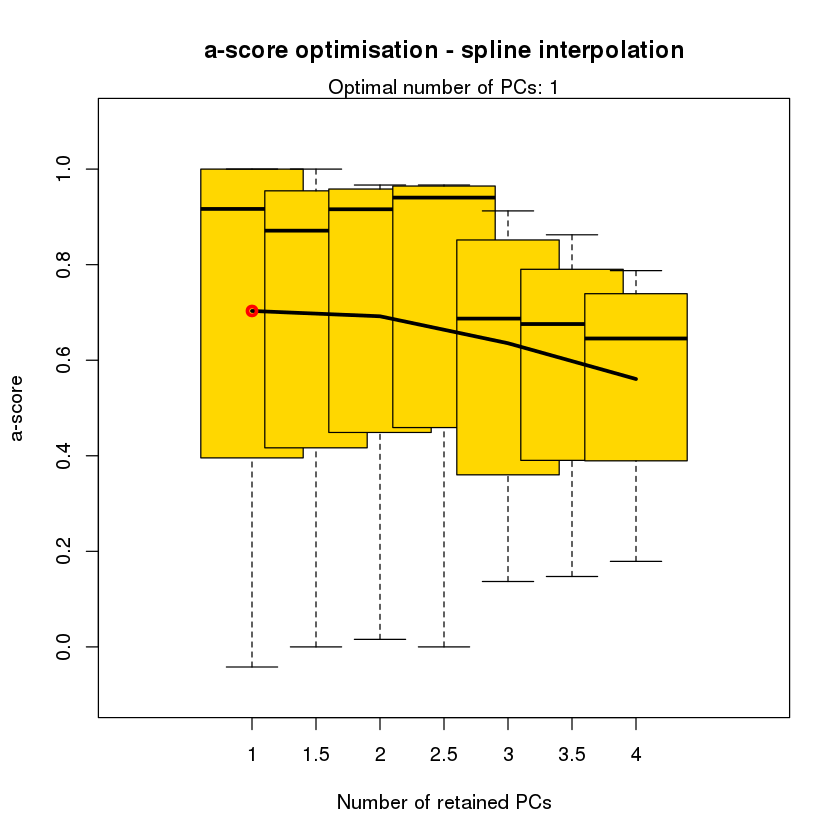

In [54]:
temp <- optim.a.score(varroa.dapc)

# K = 2

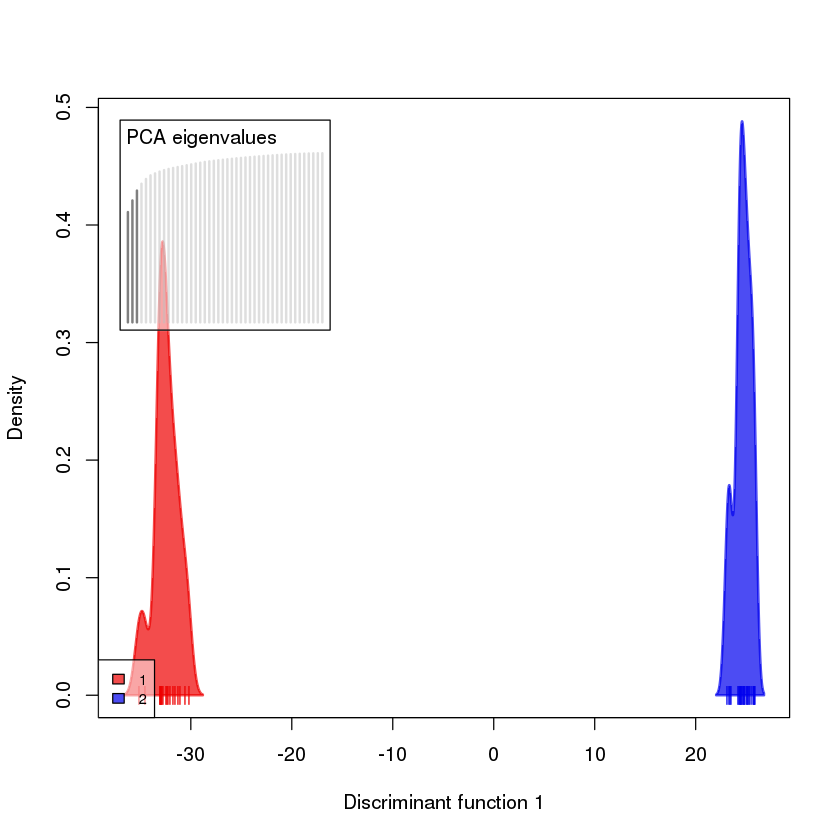

In [55]:
grp2 <- find.clusters(gl.varroa1, n.pca =3, n.clust = 2)
varroa.dapc2 <- dapc(gl.varroa1, pop=grp2$grp, n.pca = 3, n.da = 2)
scatter(varroa.dapc2, col = c("red2", "blue2"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE,
        posi.pca = "topleft", cleg = 0.75)

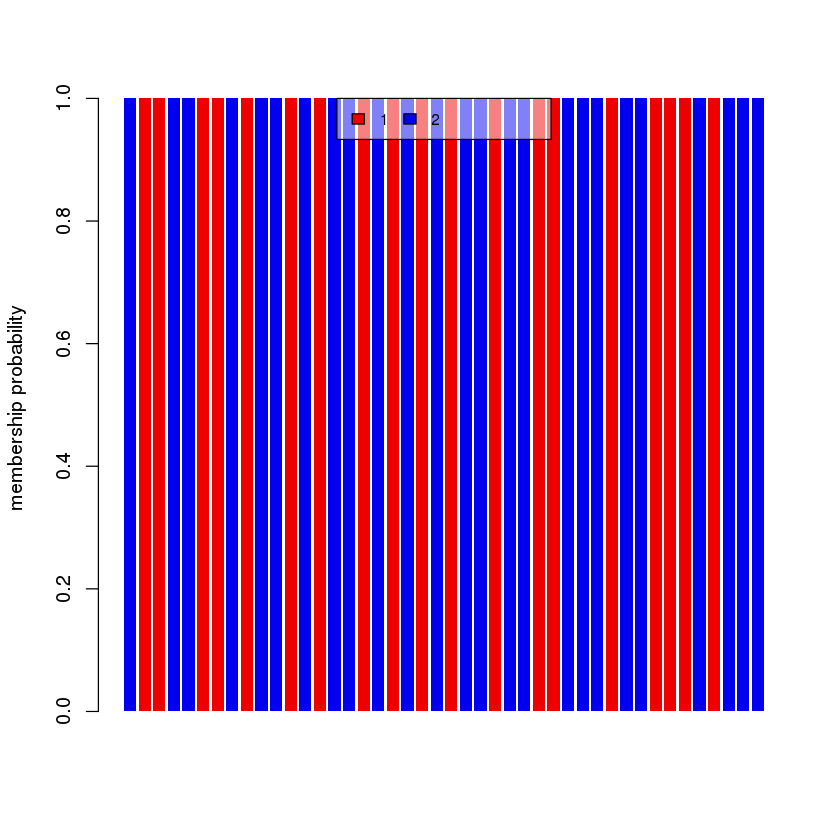

In [56]:
##Version STRUCTURE-like de la DAPC K2
compoplot(varroa.dapc2,col = c("red2", "blue2"), posi = 'top')

In [57]:
library(reshape2)
dapc.results <- as.data.frame(varroa.dapc2$posterior)
dapc.results$pop <- pop(gl.varroa1)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)

Using pop, indNames as id variables


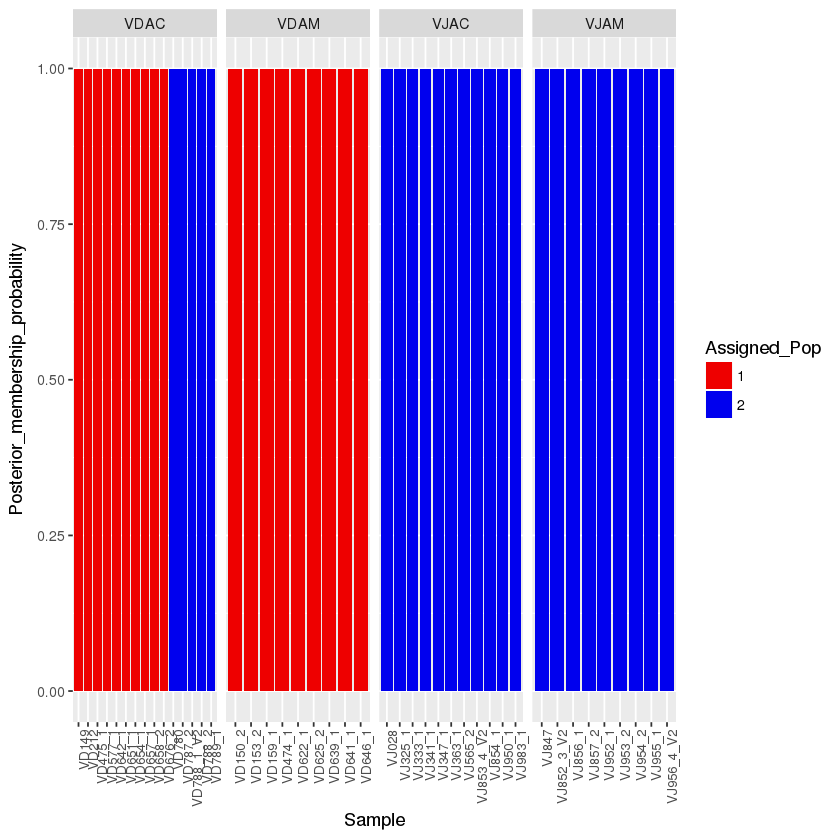

In [58]:
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
p2 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
p2 <- p2 + geom_bar(stat='identity') 
p2 <- p2 + scale_fill_manual(values = c("red2", "blue2")) 
p2 <- p2 + facet_grid(~Original_Pop, scales = "free")
p2 <- p2 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
p2

# K = 3 

In [59]:
grp3 <- find.clusters(gl.varroa1, n.pca =3, n.clust = 3)
varroa.dapc3 <- dapc(gl.varroa1, pop=grp3$grp, n.pca = 3, n.da = 2)

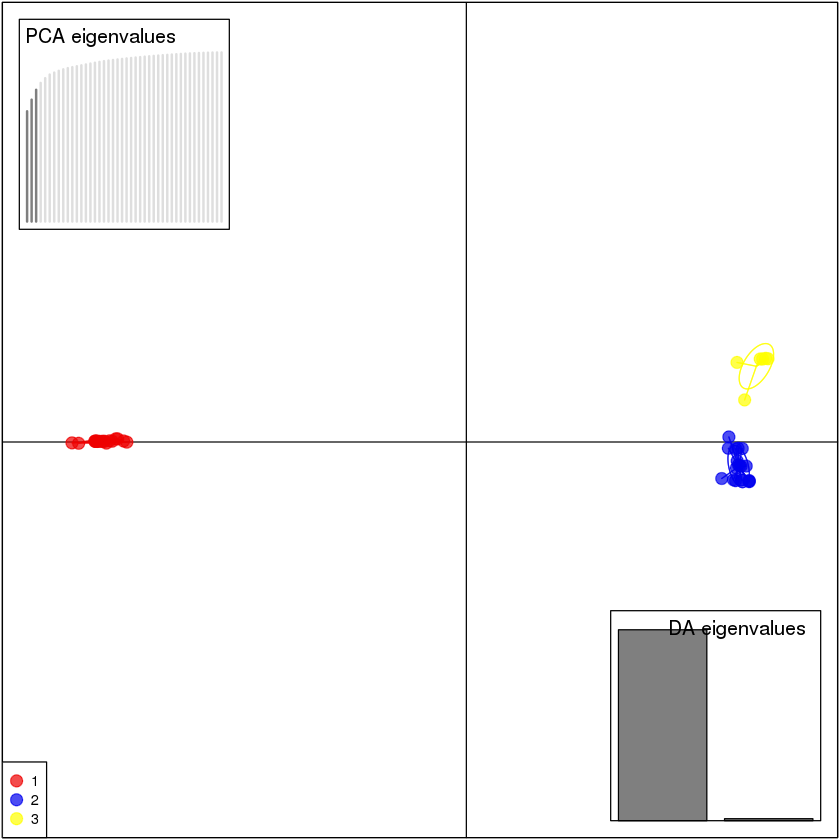

In [78]:
scatter(varroa.dapc3, col = c("red2","blue2", "yellow"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE, posi.pca = "topleft", cleg = 0.75)

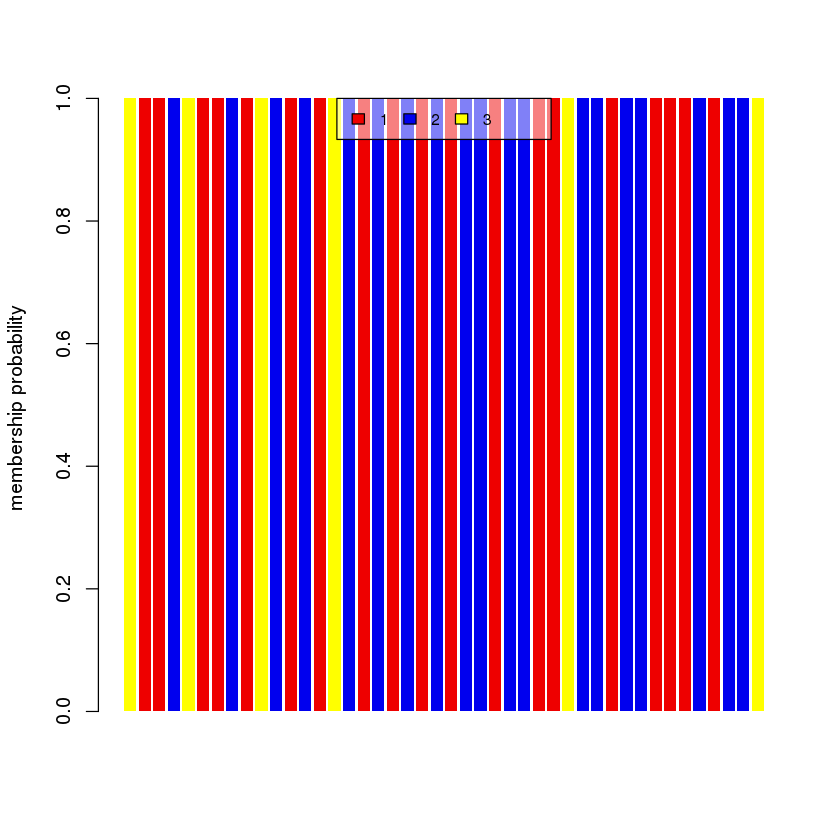

In [77]:
compoplot(varroa.dapc3,col = c("red2","blue2", "yellow"), posi = 'top')

Using pop, indNames as id variables


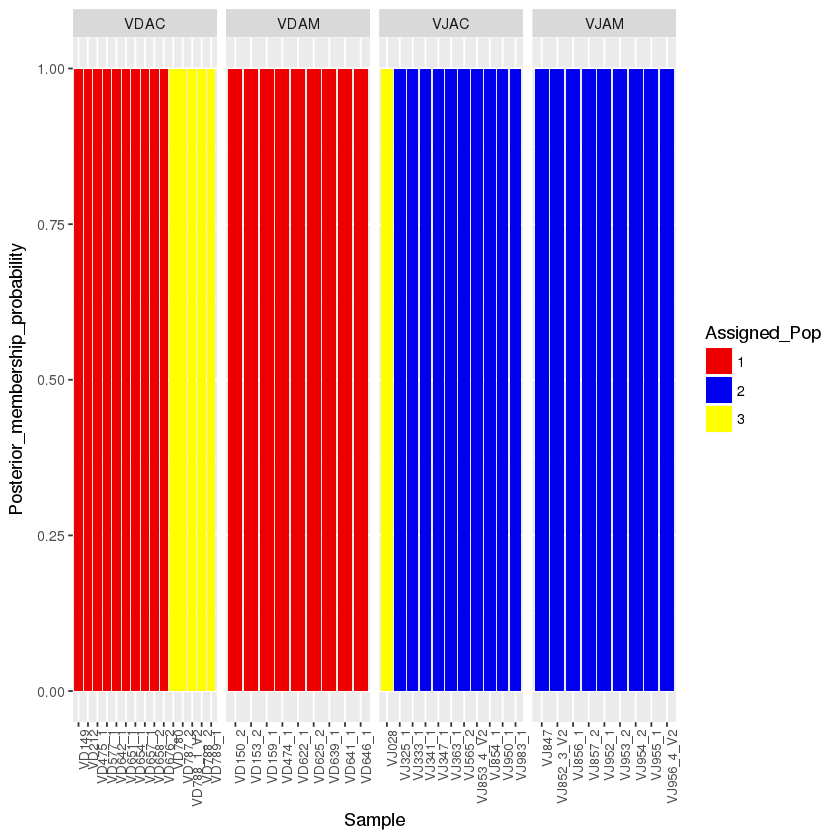

In [76]:
dapc.results <- as.data.frame(varroa.dapc3$posterior)
dapc.results$pop <- pop(gl.varroa1)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
p3 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
p3 <- p3 + geom_bar(stat='identity') 
p3 <- p3 + scale_fill_manual(values = c("red2","blue2", "yellow")) 
p3 <- p3 + facet_grid(~Original_Pop, scales = "free")
p3 <- p3 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
p3

# K = 4

In [63]:
grp4 <- find.clusters(gl.varroa1, n.pca =3, n.clust = 4)
varroa.dapc4 <- dapc(gl.varroa1, pop=grp4$grp, n.pca = 3, n.da = 2)

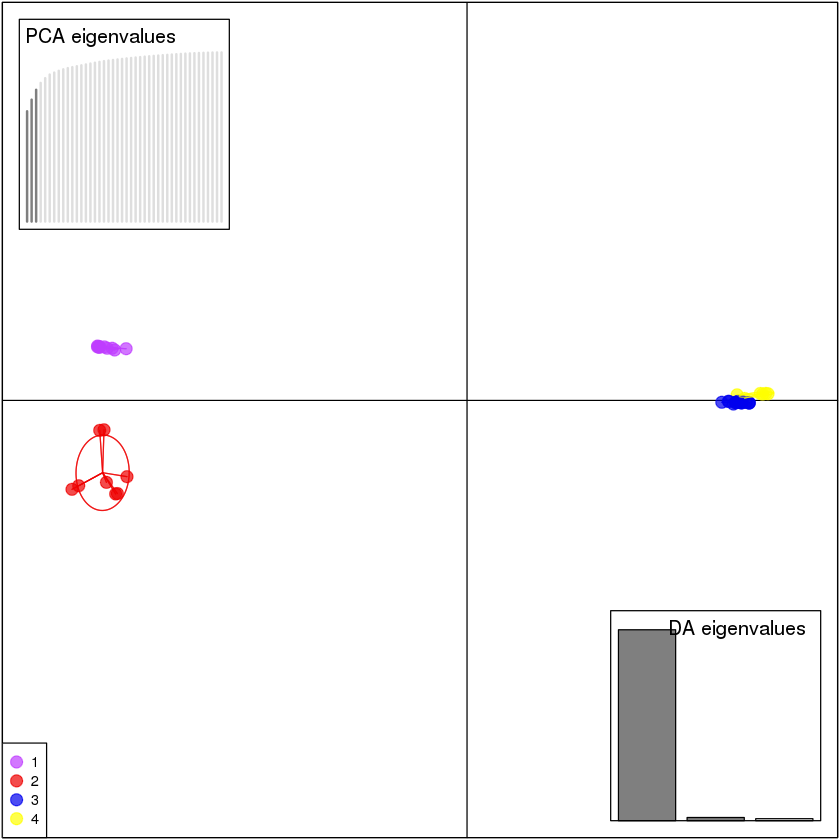

In [82]:
scatter(varroa.dapc4, col = c("darkorchid1", "red2", "blue2", "yellow"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE, posi.pca = "topleft", cleg = 0.75)

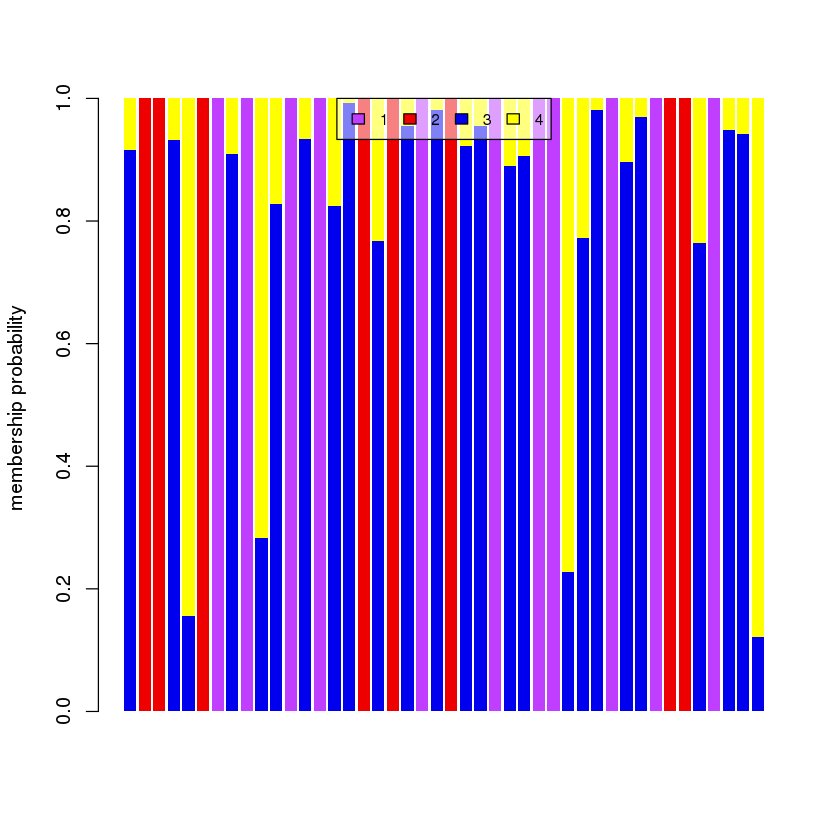

In [81]:
compoplot(varroa.dapc4, col =c("darkorchid1", "red2", "blue2", "yellow"), posi = 'top')

Using pop, indNames as id variables


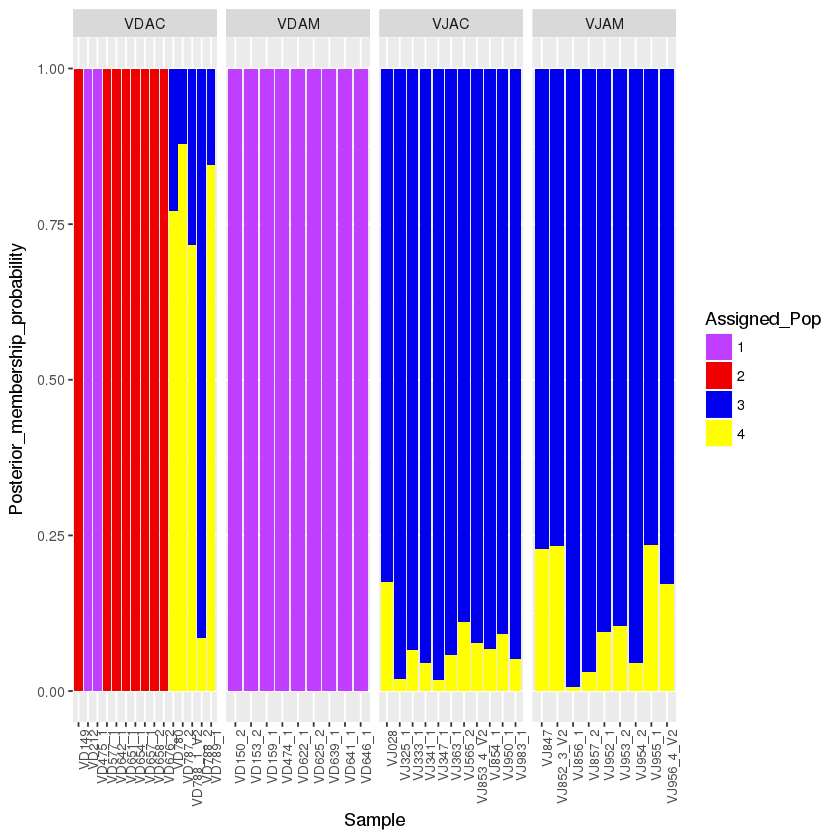

In [80]:
dapc.results <- as.data.frame(varroa.dapc4$posterior)
dapc.results$pop <- pop(gl.varroa1)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
p4 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
p4 <- p4 + geom_bar(stat='identity') 
p4 <- p4 + scale_fill_manual(values = c("darkorchid1", "red2", "blue2", "yellow")) 
p4 <- p4 + facet_grid(~Original_Pop, scales = "free")
p4 <- p4 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
p4

# K = 5

In [67]:
grp5 <- find.clusters(gl.varroa1, n.pca =3, n.clust = 5)
varroa.dapc5 <- dapc(gl.varroa1, pop=grp5$grp, n.pca = 3, n.da = 2)

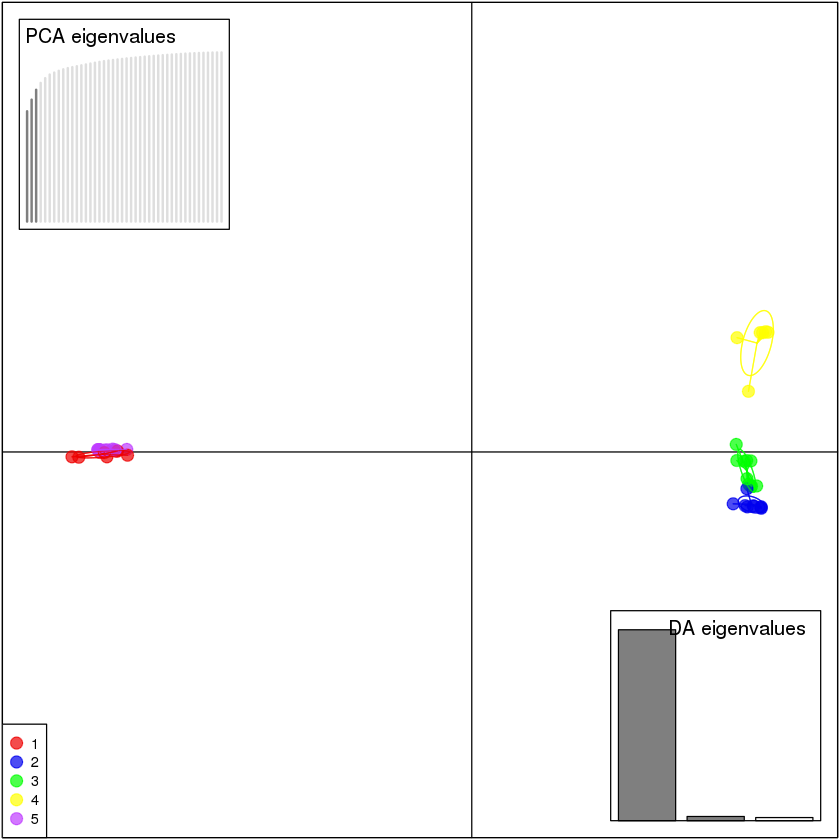

In [85]:
scatter(varroa.dapc5, col = c("red2", "blue2", "green", "yellow", "darkorchid1"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE,
        posi.pca = "topleft", cleg = 0.75)

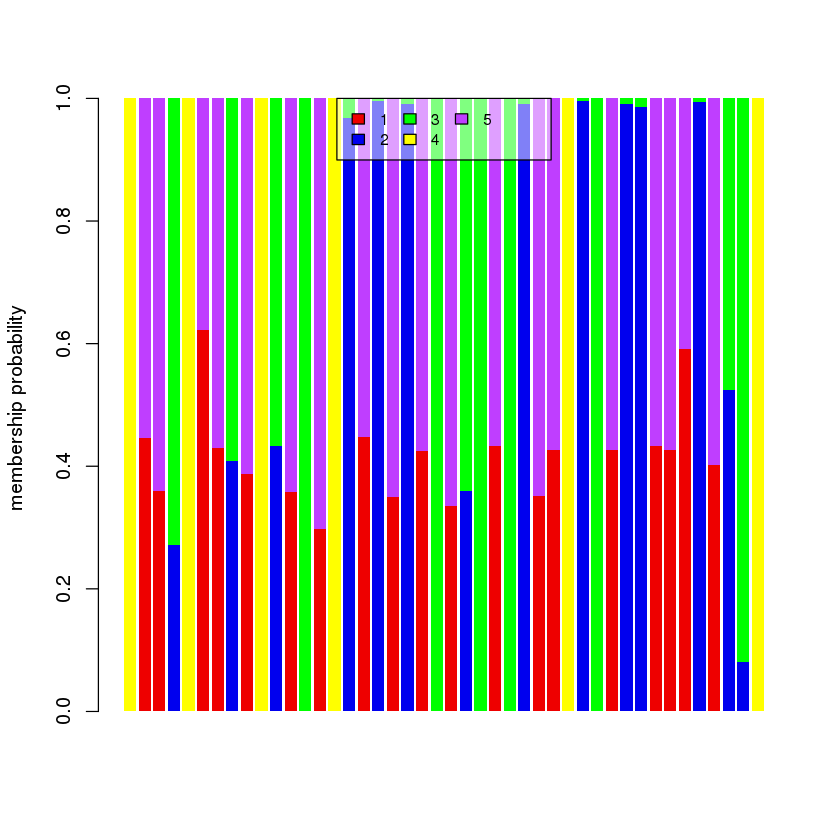

In [84]:
compoplot(varroa.dapc5,col = c("red2", "blue2", "green", "yellow", "darkorchid1"), posi = 'top')

Using pop, indNames as id variables


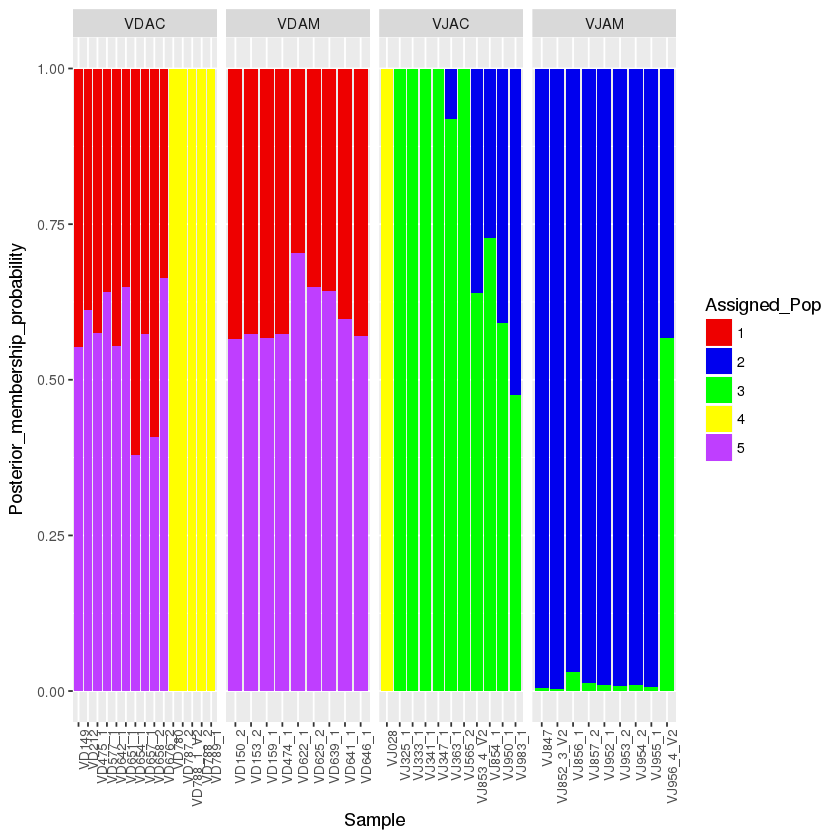

In [83]:
dapc.results <- as.data.frame(varroa.dapc5$posterior)
dapc.results$pop <- pop(gl.varroa1)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
p5 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
p5 <- p5 + geom_bar(stat='identity') 
p5 <- p5 + scale_fill_manual(values = c("red2", "blue2", "green", "yellow", "darkorchid1")) 
p5 <- p5 + facet_grid(~Original_Pop, scales = "free")
p5 <- p5 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
p5

# K = 6

In [71]:
grp6 <- find.clusters(gl.varroa1, n.pca =3, n.clust = 6)
varroa.dapc6 <- dapc(gl.varroa1, pop=grp6$grp, n.pca = 3, n.da = 2)

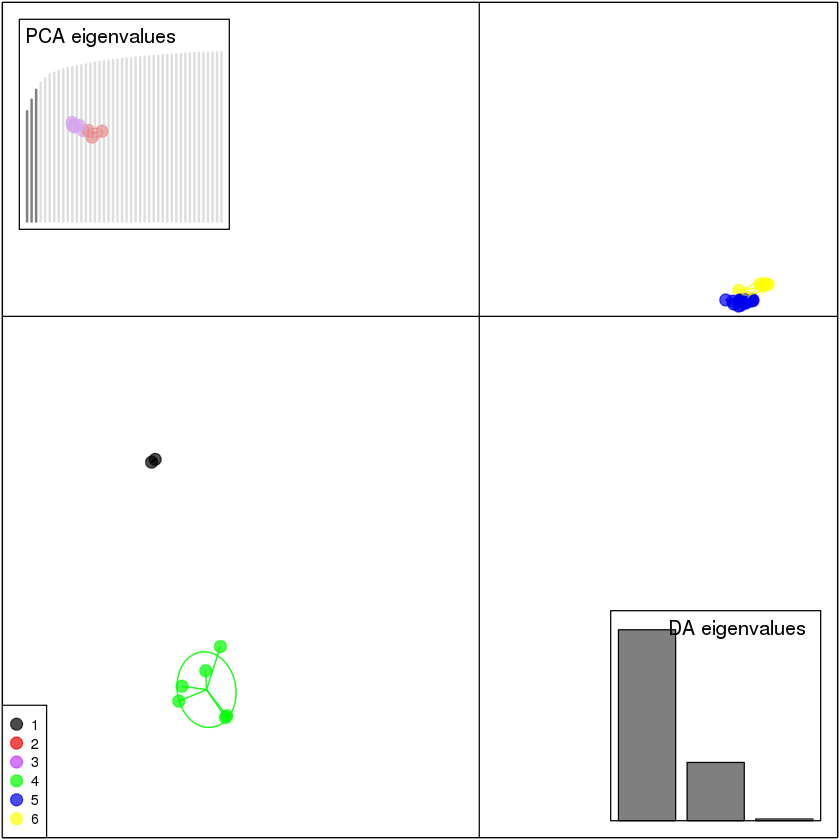

In [87]:
scatter(varroa.dapc6, col = c("black", "red2", "darkorchid1", "green", "blue2", "yellow"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE,
        posi.pca = "topleft", cleg = 0.75)

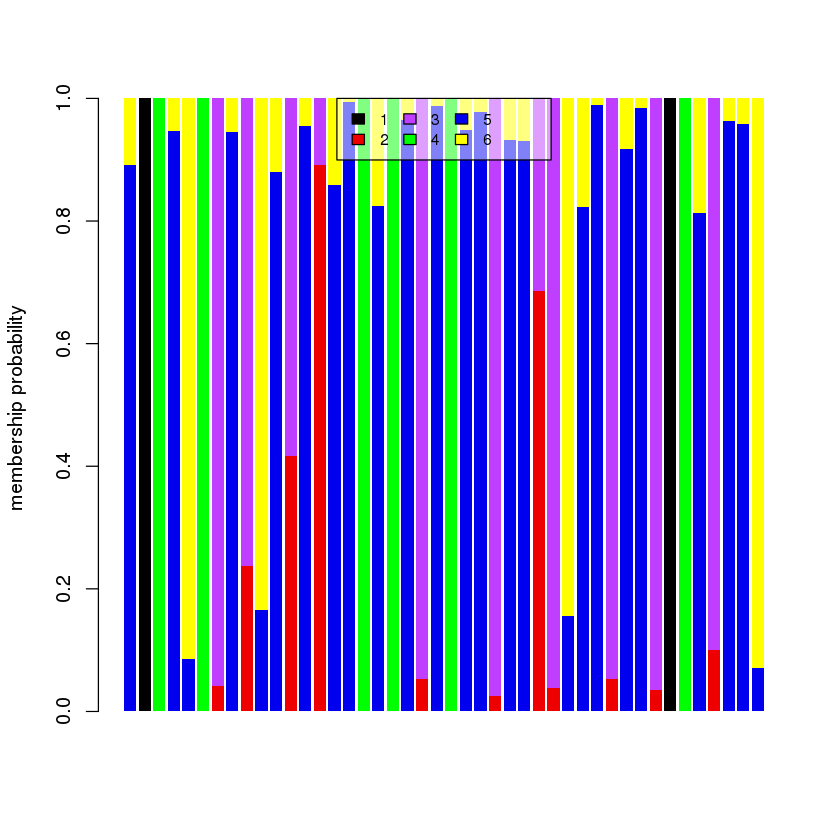

In [88]:
compoplot(varroa.dapc6,col = c("black", "red2", "darkorchid1", "green", "blue2", "yellow"), posi = 'top')

Using pop, indNames as id variables


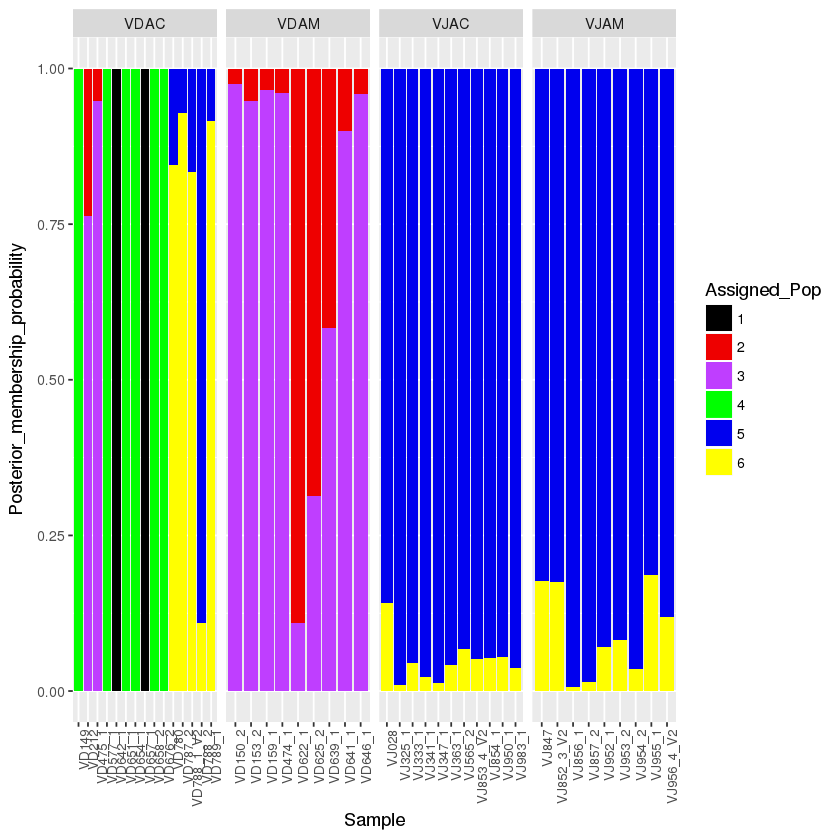

In [89]:
dapc.results <- as.data.frame(varroa.dapc6$posterior)
dapc.results$pop <- pop(gl.varroa1)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
p6 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
p6 <- p6 + geom_bar(stat='identity') 
p6 <- p6 + scale_fill_manual(values = c("black", "red2", "darkorchid1", "green", "blue2", "yellow")) 
p6 <- p6 + facet_grid(~Original_Pop, scales = "free")
p6 <- p6 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
p6

# K = 7

In [90]:
grp7 <- find.clusters(gl.varroa1, n.pca =3, n.clust = 7)
varroa.dapc7 <- dapc(gl.varroa1, pop=grp7$grp, n.pca = 3, n.da = 2)

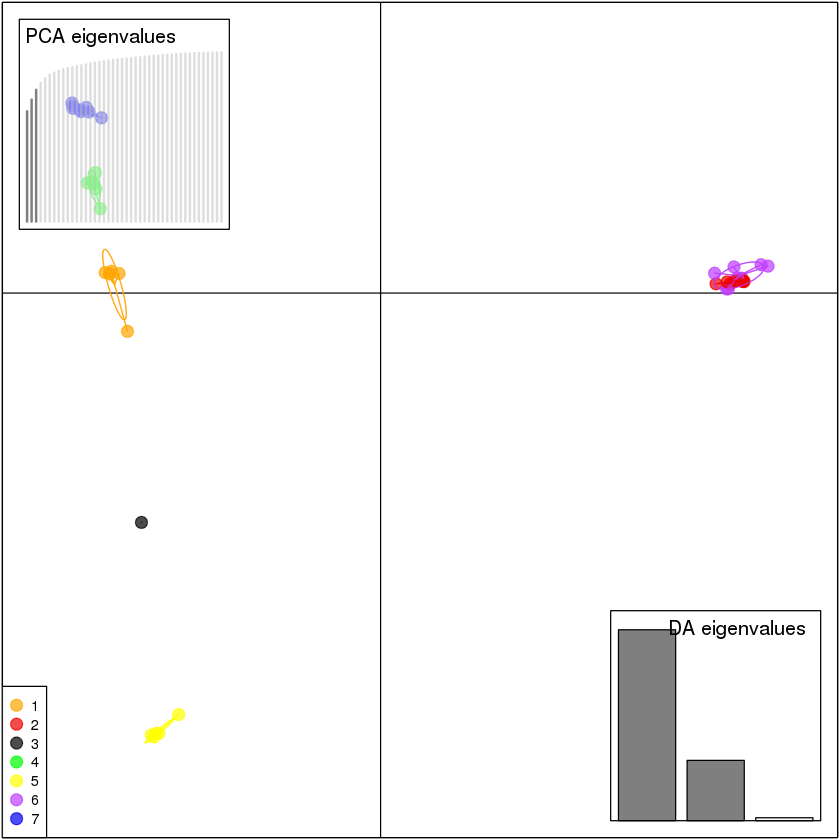

In [94]:
scatter(varroa.dapc7, col = c("orange", "red2", "black", "green", "yellow", "darkorchid1", "blue2"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE,
        posi.pca = "topleft", cleg = 0.75)

Using pop, indNames as id variables


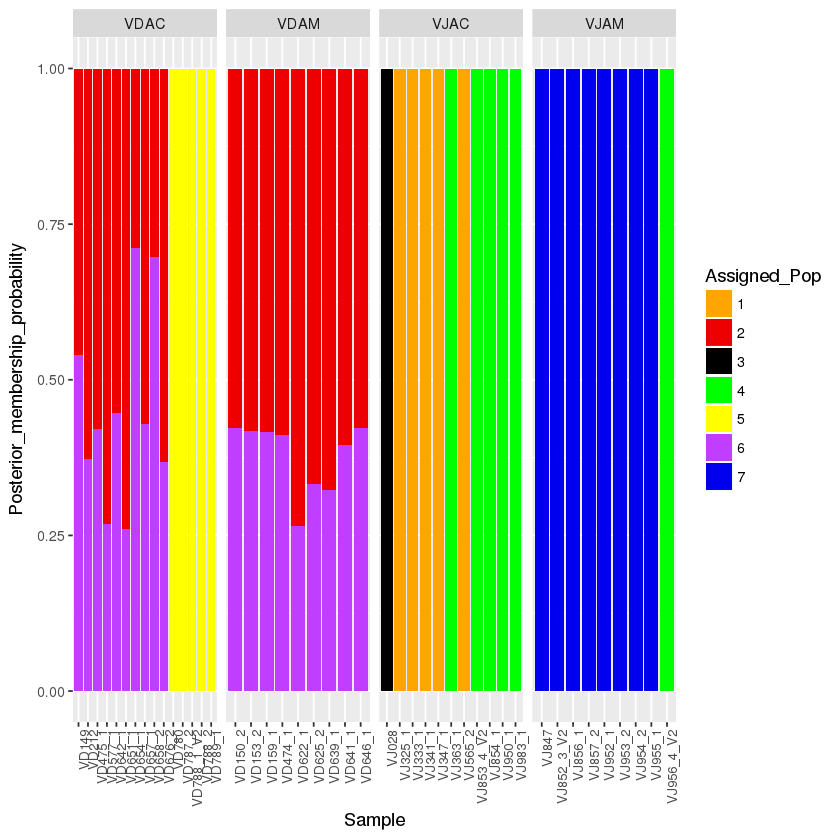

In [95]:
dapc.results <- as.data.frame(varroa.dapc7$posterior)
dapc.results$pop <- pop(gl.varroa1)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
p7 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
p7 <- p7 + geom_bar(stat='identity') 
p7 <- p7 + scale_fill_manual(values = c("orange", "red2", "black", "green", "yellow", "darkorchid1", "blue2")) 
p7 <- p7 + facet_grid(~Original_Pop, scales = "free")
p7 <- p7 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
p7

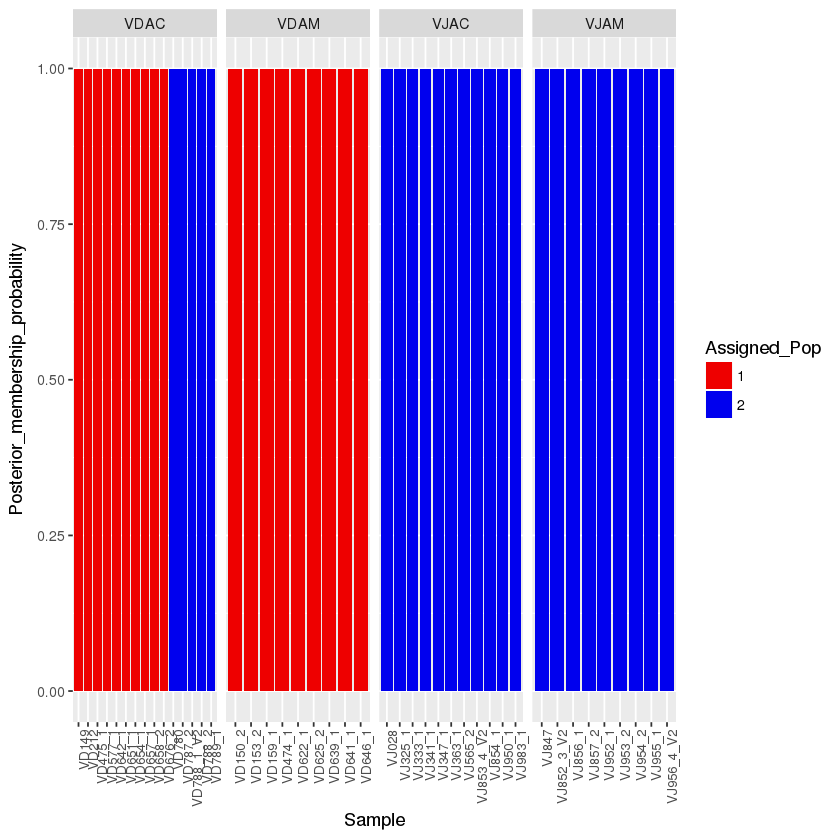

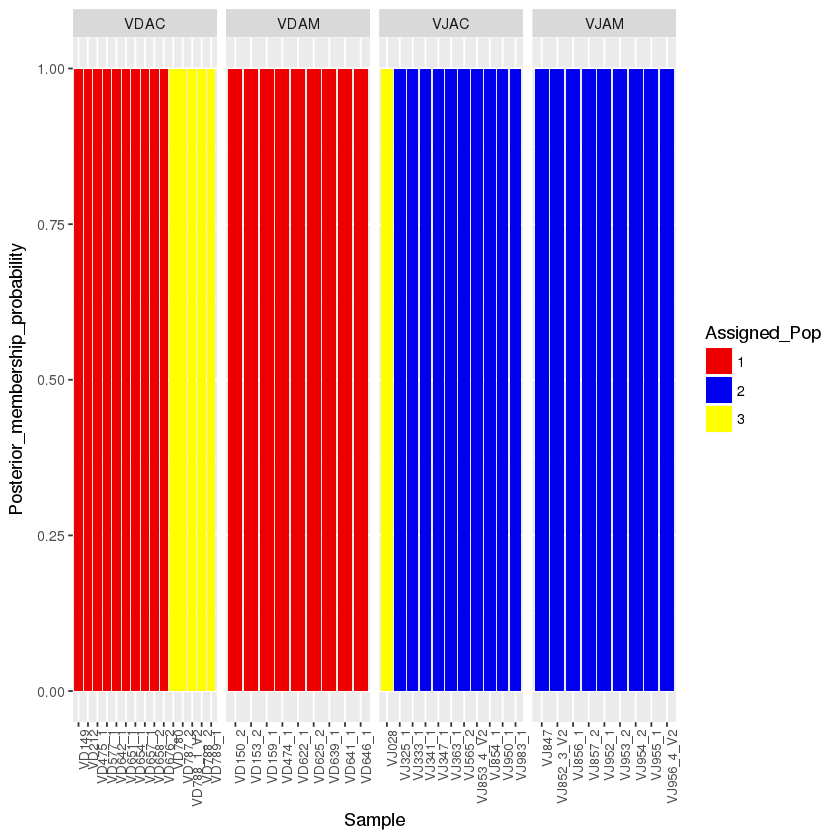

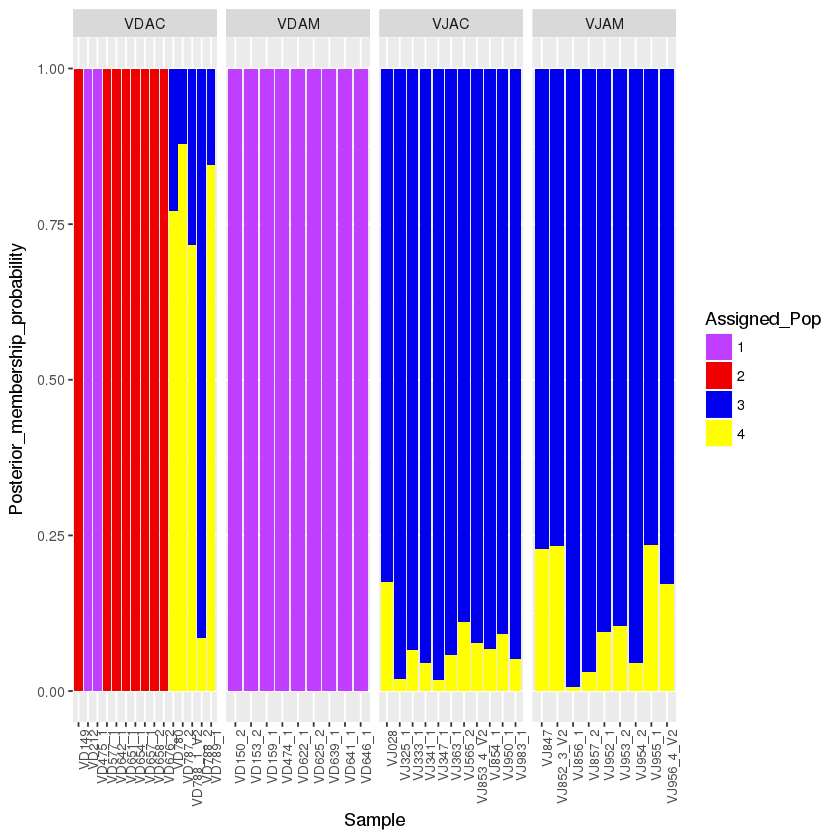

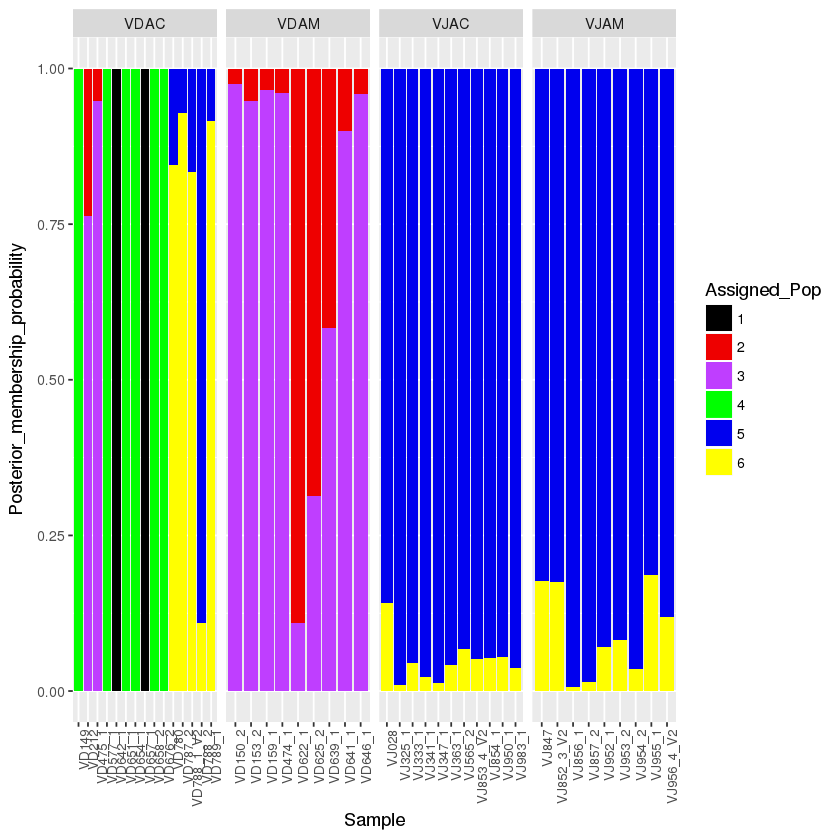

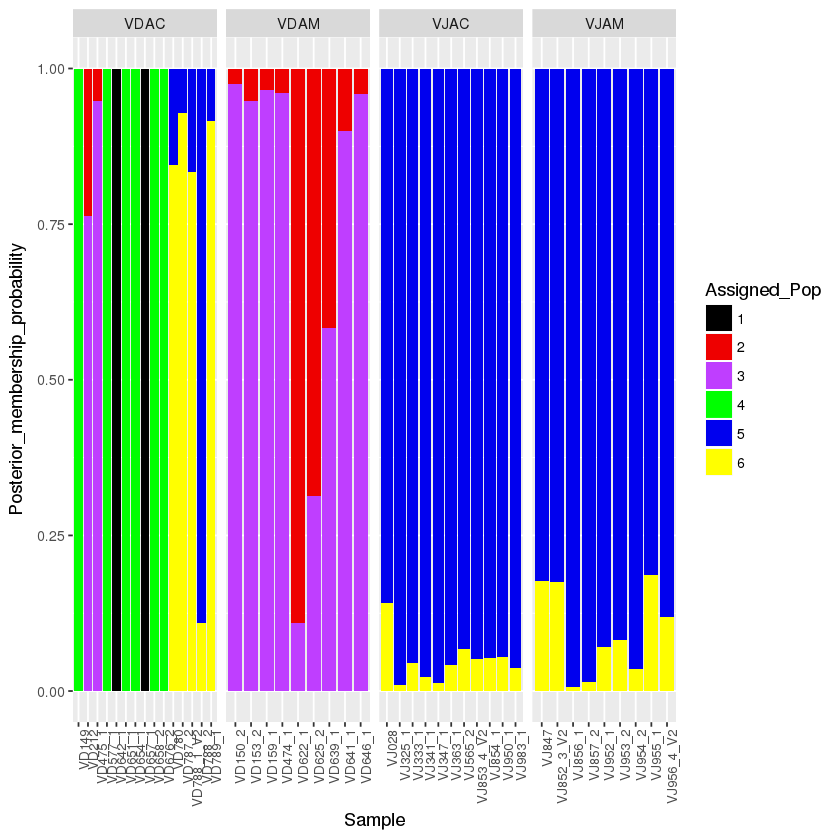

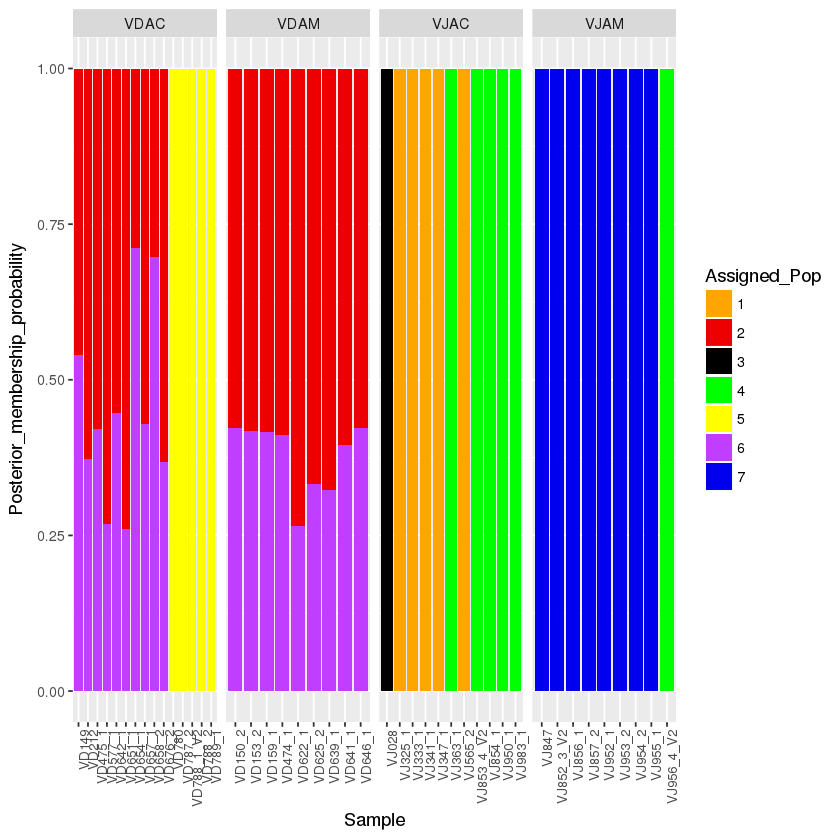

In [110]:
par(mfrow=c(6,1))
p2
p3
p4
p5
p6
p7

# Running DAPC for V. destructor on 100 000 random bi-allelic SNPs

In [8]:
pop(gl.varroa1) <- pop.data$Spe
split.gl <- seppop(gl.varroa1, pop = gl.varroa1$pop)
split.gl

$VD
 /// GENLIGHT OBJECT /////////

 // 24 genotypes,  100,000 binary SNPs, size: 9.1 Mb
 21364 (0.89 %) missing data

 // Basic content
   @gen: list of 24 SNPbin
   @ploidy: ploidy of each individual  (range: 2-2)

 // Optional content
   @ind.names:  24 individual labels
   @loc.names:  100000 locus labels
   @chromosome: factor storing chromosomes of the SNPs
   @position: integer storing positions of the SNPs
   @pop: population of each individual (group size range: 24-24)
   @other: a list containing: elements without names 


$VJ
 /// GENLIGHT OBJECT /////////

 // 20 genotypes,  100,000 binary SNPs, size: 8.9 Mb
 4739 (0.24 %) missing data

 // Basic content
   @gen: list of 20 SNPbin
   @ploidy: ploidy of each individual  (range: 2-2)

 // Optional content
   @ind.names:  20 individual labels
   @loc.names:  100000 locus labels
   @chromosome: factor storing chromosomes of the SNPs
   @position: integer storing positions of the SNPs
   @pop: population of each individual (grou

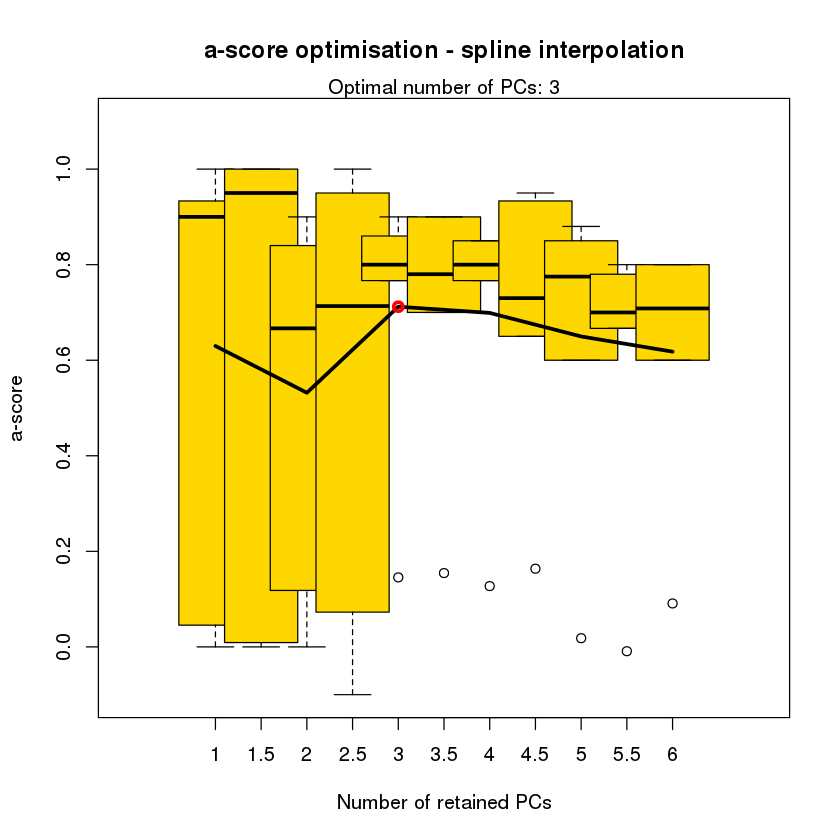

In [9]:
vd.grp <- find.clusters(split.gl$VD, n.pca = 6, n.clust = 6)
vd.dapc <- dapc(split.gl$VD, pop=vd.grp$grp, n.pca = 6, n.da = 2)
temp <- optim.a.score(vd.dapc)

# K = 2 for Vd 

In [105]:
vd2 <- find.clusters(split.gl$VD, n.pca =2, n.clust = 2)
vd.dapc2 <- dapc(split.gl$VD, pop=vd2$grp, n.pca = 2, n.da = 1)

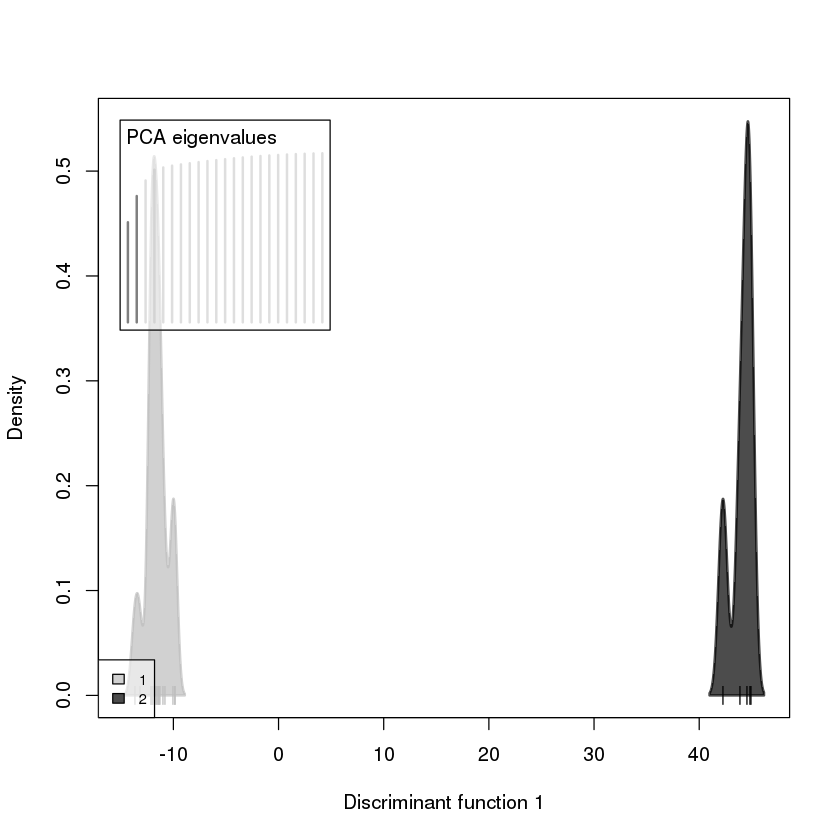

In [106]:
scatter(vd.dapc2, col = c("gray", "black"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE,
        posi.pca = "topleft", cleg = 0.75)

Using pop, indNames as id variables


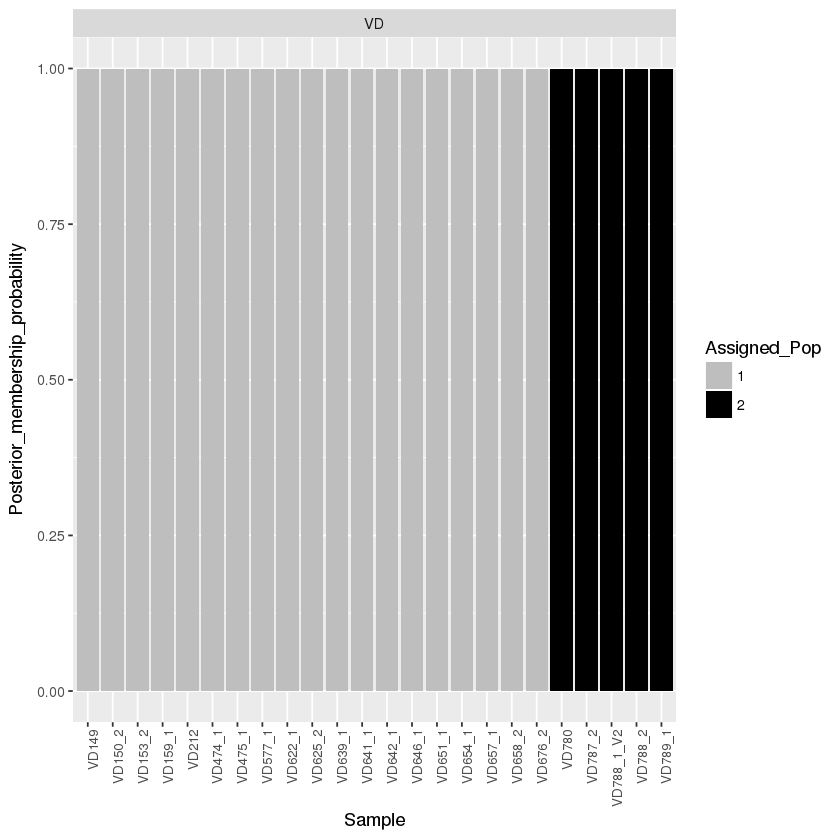

In [107]:
dapc.results <- as.data.frame(vd.dapc2$posterior)
dapc.results$pop <- pop(split.gl$VD)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
pvd2 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
pvd2 <- pvd2 + geom_bar(stat='identity') 
pvd2 <- pvd2 + scale_fill_manual(values = c("gray", "black")) 
pvd2 <- pvd2 + facet_grid(~Original_Pop, scales = "free")
pvd2 <- pvd2 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
pvd2

# K = 3 for Vd 

In [112]:
vd3 <- find.clusters(split.gl$VD, n.pca =2, n.clust = 3)
vd.dapc3 <- dapc(split.gl$VD, pop=vd3$grp, n.pca = 2, n.da = 2)

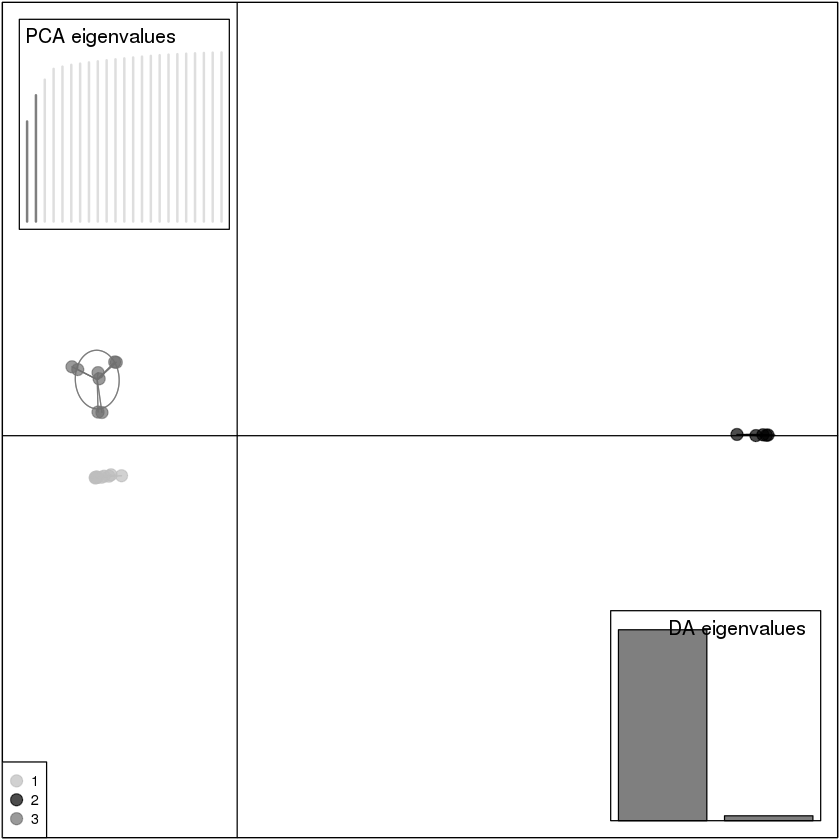

In [115]:
scatter(vd.dapc3, col = c("gray", "black", "grey44"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE,
        posi.pca = "topleft", cleg = 0.75)

Using pop, indNames as id variables


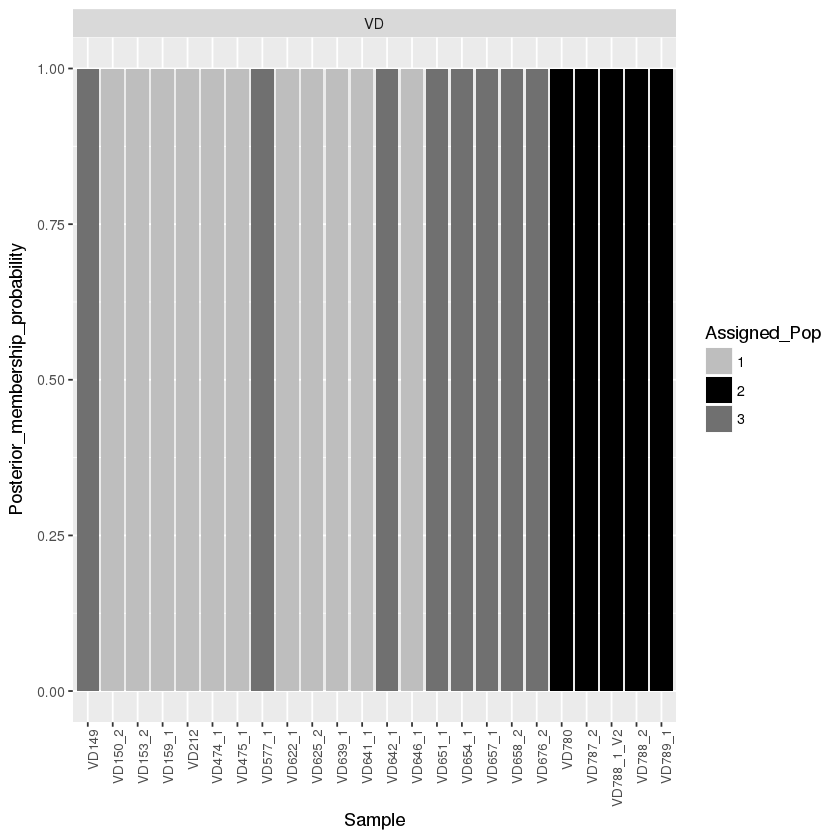

In [114]:
dapc.results <- as.data.frame(vd.dapc3$posterior)
dapc.results$pop <- pop(split.gl$VD)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
pvd3 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
pvd3 <- pvd3 + geom_bar(stat='identity') 
pvd3 <- pvd3 + scale_fill_manual(values = c("gray", "black", "grey44")) 
pvd3 <- pvd3 + facet_grid(~Original_Pop, scales = "free")
pvd3 <- pvd3 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
pvd3

# K = 4 for Vd 

In [116]:
vd4 <- find.clusters(split.gl$VD, n.pca =2, n.clust = 4)
vd.dapc4 <- dapc(split.gl$VD, pop=vd4$grp, n.pca = 2, n.da = 2)

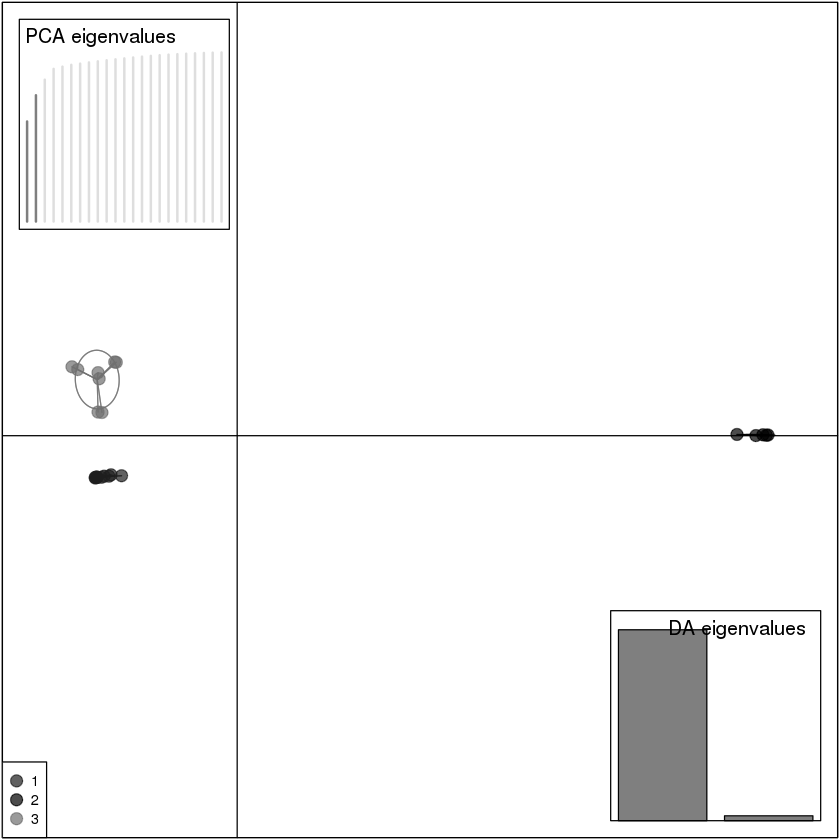

In [120]:
scatter(vd.dapc3, col = c("grey12", "black", "grey44", "gray"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE,
        posi.pca = "topleft", cleg = 0.75)

Using pop, indNames as id variables


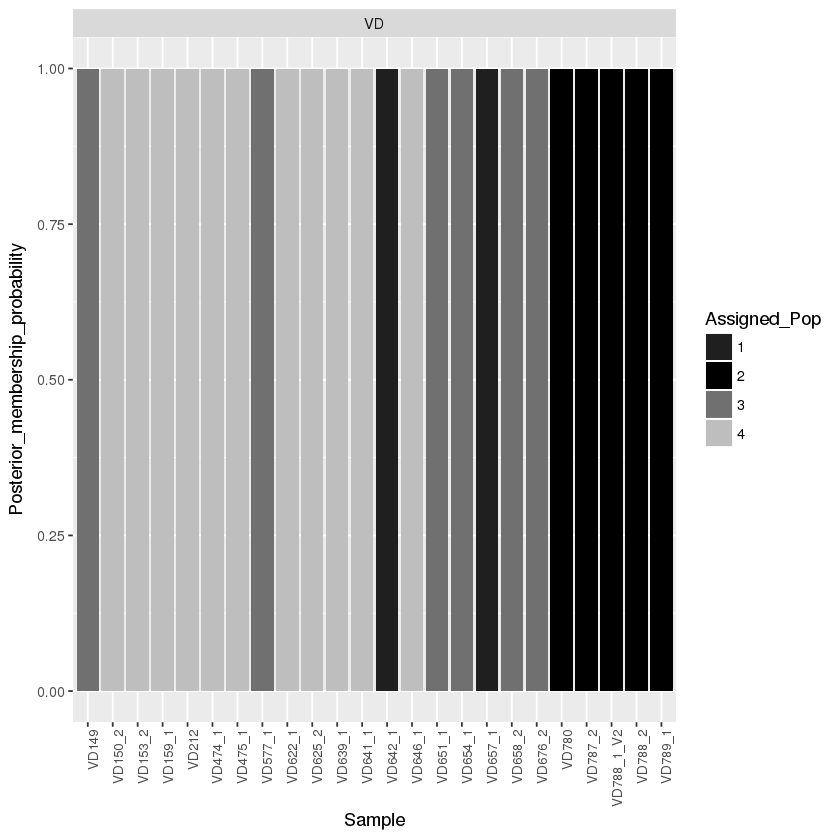

In [119]:
dapc.results <- as.data.frame(vd.dapc4$posterior)
dapc.results$pop <- pop(split.gl$VD)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
pvd4 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
pvd4 <- pvd4 + geom_bar(stat='identity') 
pvd4 <- pvd4 + scale_fill_manual(values = c("grey12", "black", "grey44", "gray")) 
pvd4 <- pvd4 + facet_grid(~Original_Pop, scales = "free")
pvd4 <- pvd4 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
pvd4

# K = 5 for Vd

In [13]:
vd5 <- find.clusters(split.gl$VD, n.pca =2, n.clust = 5)
vd.dapc5 <- dapc(split.gl$VD, pop=vd5$grp, n.pca = 2, n.da = 2)

ERROR: Error in parse(text = x, srcfile = src): <text>:2:64: unexpected symbol
1: vd5 <- find.clusters(split.gl$VD, n.pca =2, n.clust = 5)
2: vd.dapc5 <- dapc(split.gl$VD, pop=vd5$grp, n.pca = 2, n.da = 2)dapc.results
                                                                  ^


Using pop, indNames as id variables


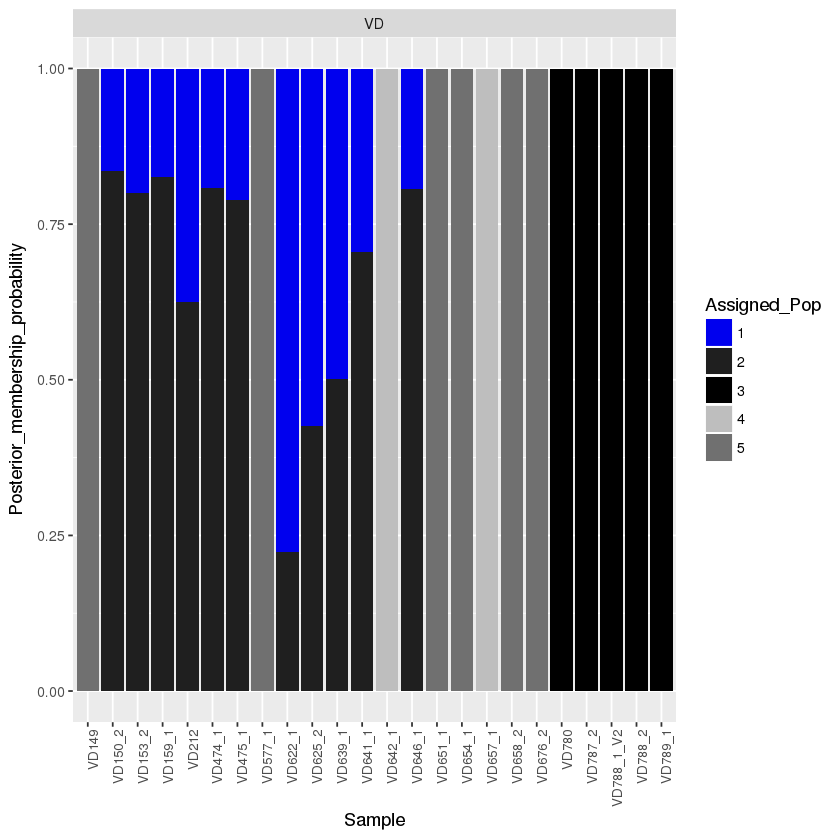

In [16]:
library(reshape2)
dapc.results <- as.data.frame(vd.dapc5$posterior)
dapc.results$pop <- pop(split.gl$VD)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
pvd5 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
pvd5 <- pvd5 + geom_bar(stat='identity') 
pvd5 <- pvd5 + scale_fill_manual(values = c("blue2", "grey12", "black", "gray", "grey44")) 
pvd5 <- pvd5 + facet_grid(~Original_Pop, scales = "free")
pvd5 <- pvd5 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
pvd5

# Running DAPC for V. jacobsoni on 100 000 random bi-allelic SNPs

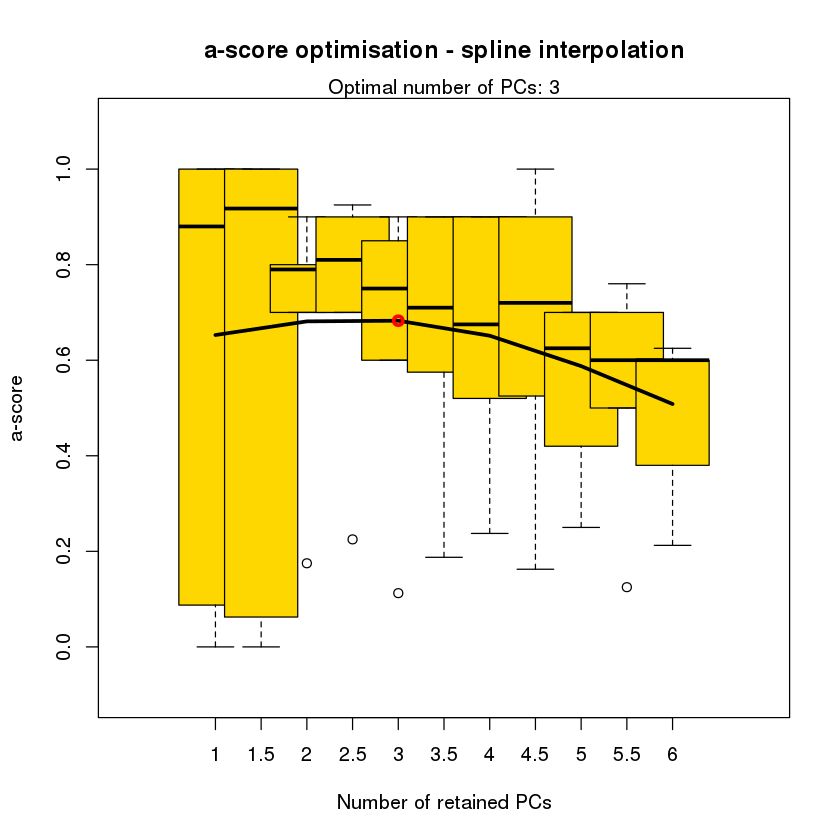

In [10]:
vj.grp <- find.clusters(split.gl$VJ, n.pca = 6, n.clust = 6)
vj.dapc <- dapc(split.gl$VJ, pop=vj.grp$grp, n.pca = 6, n.da = 2)
temp <- optim.a.score(vj.dapc)

# K = 2 for VJ

In [17]:
vj2 <- find.clusters(split.gl$VJ, n.pca =2, n.clust = 2)
vj.dapc2 <- dapc(split.gl$VJ, pop=vj2$grp, n.pca = 2, n.da = 1)

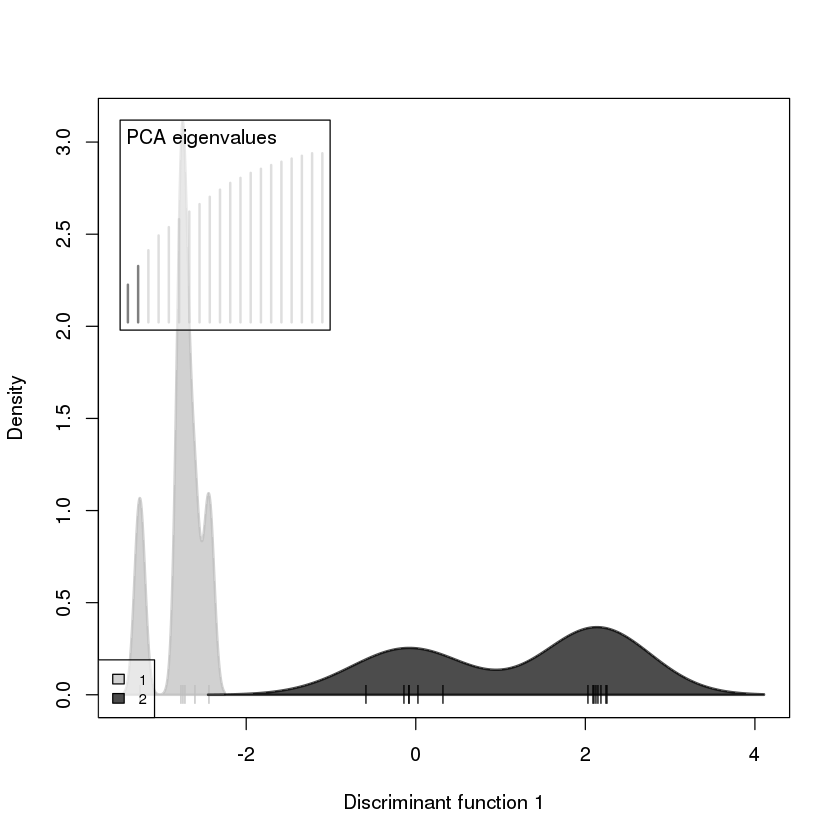

In [19]:
scatter(vj.dapc2, col = c("gray", "black"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE,
        posi.pca = "topleft", cleg = 0.75)

Using pop, indNames as id variables


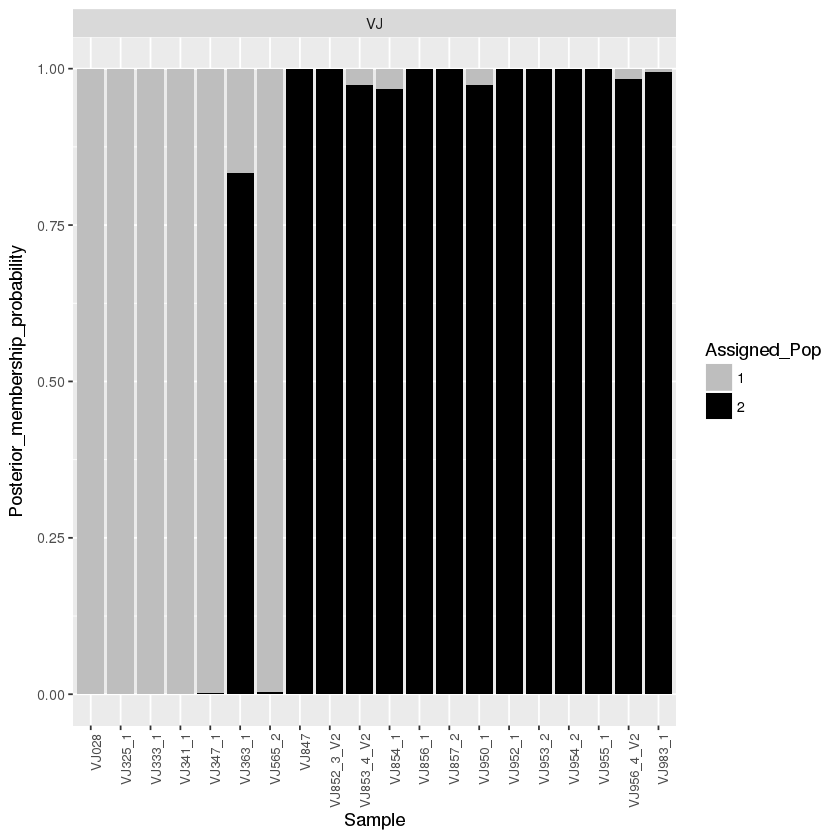

In [18]:
dapc.results <- as.data.frame(vj.dapc2$posterior)
dapc.results$pop <- pop(split.gl$VJ)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
pvj2 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
pvj2 <- pvj2 + geom_bar(stat='identity') 
pvj2 <- pvj2 + scale_fill_manual(values = c("gray", "black")) 
pvj2 <- pvj2 + facet_grid(~Original_Pop, scales = "free")
pvj2 <- pvj2 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
pvj2

# K = 3 for VJ

In [20]:
vj3 <- find.clusters(split.gl$VJ, n.pca =2, n.clust = 3)
vj.dapc3 <- dapc(split.gl$VJ, pop=vj3$grp, n.pca = 2, n.da = 1)

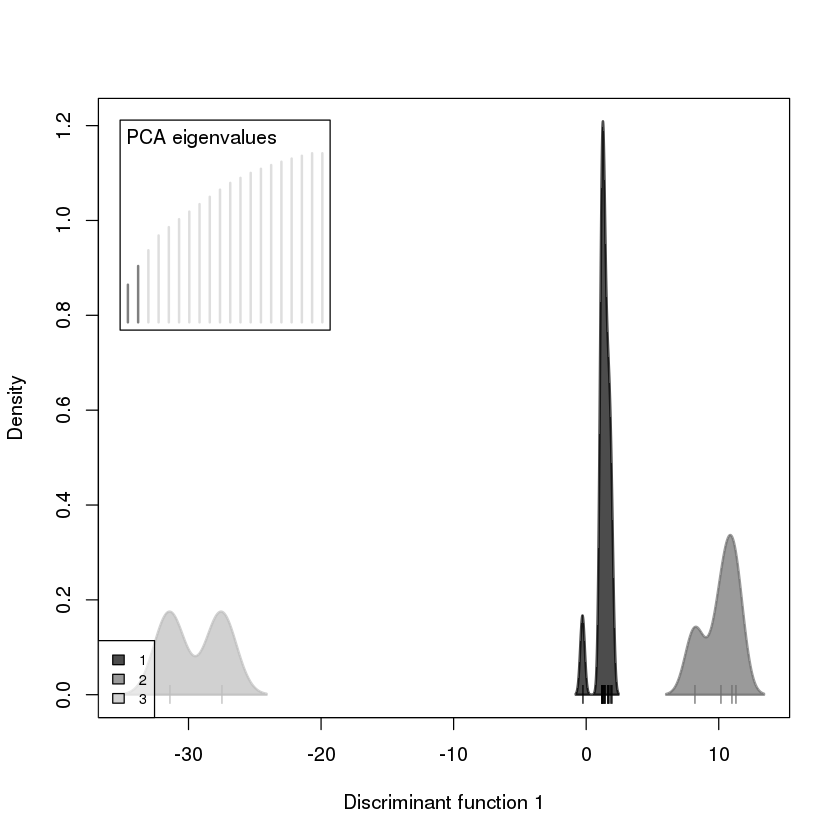

In [23]:
scatter(vj.dapc3, col = c("black", "grey44", "gray"), cex = 2, legend = TRUE, clabel = F, posi.leg = "bottomleft", scree.pca = TRUE,
        posi.pca = "topleft", cleg = 0.75)

Using pop, indNames as id variables


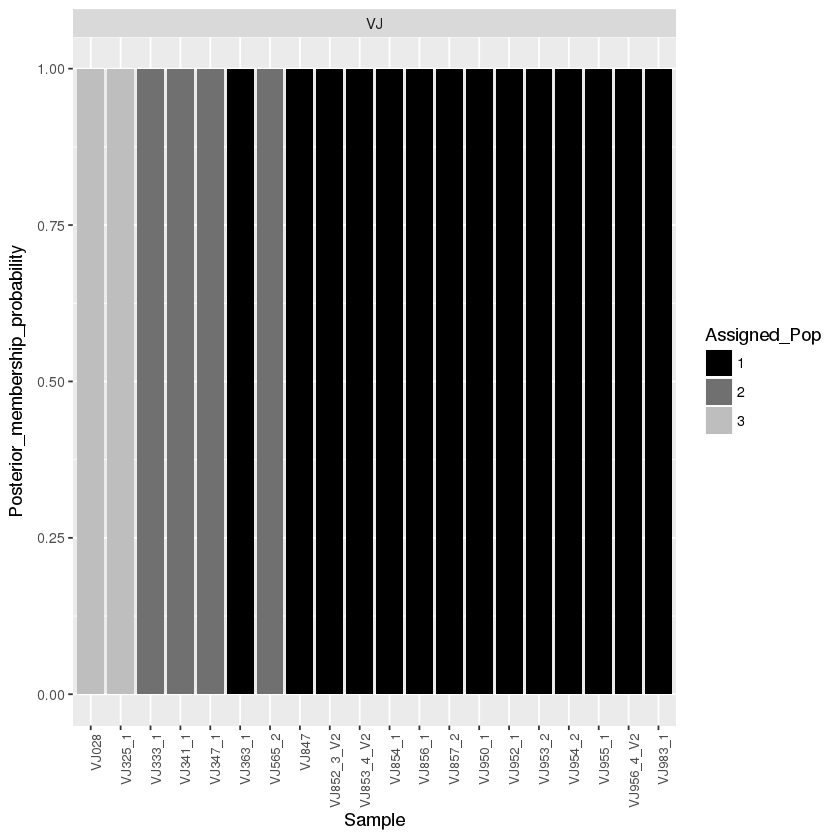

In [22]:
dapc.results <- as.data.frame(vj.dapc3$posterior)
dapc.results$pop <- pop(split.gl$VJ)
dapc.results$indNames <- rownames(dapc.results)
dapc.results <- melt(dapc.results)
colnames(dapc.results) <- c("Original_Pop","Sample","Assigned_Pop","Posterior_membership_probability")
pvj3 <- ggplot(dapc.results, aes(x=Sample, y=Posterior_membership_probability, fill=Assigned_Pop))
pvj3 <- pvj3 + geom_bar(stat='identity') 
pvj3 <- pvj3 + scale_fill_manual(values = c("black", "grey44", "gray")) 
pvj3 <- pvj3 + facet_grid(~Original_Pop, scales = "free")
pvj3 <- pvj3 + theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
pvj3